# 1. Set Up Notebook and Load Data 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import fnmatch
import pickle
import ipywidgets as widgets
from IPython.display import display
import sys
import os
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Input, Flatten, Dense, Conv2DTranspose, LeakyReLU, BatchNormalization,  LeakyReLU,  Activation, LSTM, TimeDistributed, RepeatVector, Lambda, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.activations import elu
from tensorflow.keras.initializers import HeUniform, GlorotUniform, HeNormal, LecunNormal
from tensorflow.keras import regularizers



# CUSTOM Imports
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Num GPUs Available:  1
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.0


Dropdown(description='Set :', index=1, options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='All')

In [2]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist2D*24*minmax*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget

Dropdown(description='TSNE File :', options=('hist2D-All-nE16-nt24-normminmax.pkl',), value='hist2D-All-nE16-n…

In [3]:
# Load features
input_file = input_widget.value
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
ids = list(hist_dict.keys())
histograms = hist_dict.values()
features = np.array([np.array(h) for h in histograms])
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index(drop=True)
# Data
df_label = df_properties.copy()
df_label_h = df_label[['obsreg_id','hard_hs', 'hard_hm','hard_ms']]
df_label_v = df_label[['obsreg_id','var_prob_b','var_prob_h','var_prob_m','var_prob_s','var_index_b']]
mask_nonan_h = df_label_h.notna().all(axis=1)
mask_nonan_v = df_label_v.notna().all(axis=1)
index_nonan_h = list(df_label_h.notna().all(axis=1).index[df_label_h.notna().all(axis=1)])
index_nonan_v = list(df_label_v.notna().all(axis=1).index[df_label_v.notna().all(axis=1)])
df_label_h = df_label_h[mask_nonan_h]
df_label_v = df_label_v[mask_nonan_v]

hr_hs = np.array(df_label_h['hard_hs'].values)
hr_hm = np.array(df_label_h['hard_hm'].values)
hr_ms = np.array(df_label_h['hard_ms'].values)

var_b = np.array(df_label_v['var_prob_b'].values)
var_h = np.array(df_label_v['var_prob_h'].values)
var_m = np.array(df_label_v['var_prob_m'].values)
var_s = np.array(df_label_v['var_prob_s'].values)
var_index = np.array(df_label_v['var_index_b'].values)

yh = np.vstack((hr_hs, hr_hm, hr_ms)).T
desc_h = ['HR HS', 'HR HM', 'HR MS']
yv = np.vstack((var_b, var_h, var_m, var_s, var_index)).T
desc_v = ['VAR B', 'VAR H', 'VAR M', 'VAR S', 'VAR INDEX']

In [4]:
prop_option = ['HR', 'VAR']

prop_widget = widgets.Dropdown(options=prop_option[:],value=prop_option[0],description='Property:',disabled=False); prop_widget

Dropdown(description='Property:', options=('HR', 'VAR'), value='HR')

In [5]:
prop = prop_widget.value

if prop == 'HR':
    y = yh
    dfp = df_label_h
    X = np.array([features[i].flatten() for i in index_nonan_h])
    npred = 3
    desc = desc_h
    active = 'tanh'
elif prop == 'VAR':
    y = yv
    dfp = df_label_v
    X = np.array([features[i].flatten() for i in index_nonan_v])
    npred = 4
    desc = desc_v
    active = 'sigmoid'

ID = dfp['obsreg_id'].values
rs = 505
splits = 0.2
X_train, X_test, ID_train, ID_test, y_train, y_test = train_test_split(X, ID, y, test_size=splits, random_state=rs)
# Print Summary
print ('Training Set X', X_train.shape)
print ('Test Set X', X_test.shape)
print ('Training Set Y', y_train.shape)
print ('Test Set Y', y_test.shape)

Training Set X (64708, 384)
Test Set X (16177, 384)
Training Set Y (64708, 3)
Test Set Y (16177, 3)


# 3. Predictor Model

In [8]:
#Settings
input_shape = (384,)
in1 = 24
in2 = 16
layers = [256,64,16]
activation = 'relu' #LeakyReLU(alpha=0.1) # 'relu'# 'selu' #LeakyReLU(alpha=0.1) #'relu' #LeakyReLU(alpha=0.1) #'relu' #LeakyReLU(alpha=0.2) # 'selu' # LeakyReLU(alpha=0.2)
kernel_init = 'he_normal'  #'he_normal' #HeUniform(seed=505) # LecunNormal(seed=42) #  #'he_normal' # # #'glorot_uniform'# 'he_normal' #'glorot_uniform' #'he_normal' #'glorot_uniform'
lr = 0.001
epochs = 250
batch = 1024
# Define encoder
model = Sequential()
model.add(Lambda(lambda x: x, input_shape=input_shape))
for dim in layers:
    model.add(Dense(dim, activation=activation, kernel_initializer = kernel_init))
    # model.add(BatchNormalization(momentum=0.9))
model.add(Dense(npred))
# Training Set Up
optimizer = Adam(learning_rate = lr)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
loss_function = 'mse'
model.compile(optimizer=optimizer, loss=loss_function)
model.summary()
# Training 
name = input('Name: ')
print(name)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10) #min_lr=0.0000001
history = model.fit(X_train, y_train, epochs=epochs,batch_size=batch,validation_data=(X_test, y_test),callbacks=[reduce_lr_callback, early_stopping]) # 128 or 256, 512, 1024, 2048, 4096
# Saving
model.save(f'{global_path}/{set_id}/PREDICTOR-{prop}-2D-CNN-layers{layers}-lr{lr}-b{batch}-{name}.h5')
with open(f'{global_path}/{set_id}/PREDICTOR-{prop}-HISTORY-2D-CNN-layers{layers}-lr{lr}-b{batch}-{name}.pickle', 'wb') as file:
    pickle.dump(history.history, file)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 384)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               98560     
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 3)                 51        
                                                                 
Total params: 116,099
Trainable params: 116,099
Non-trainable params: 0
_________________________________________________________________

Epoch 1/250
64/64 [============================

In [9]:
# Select saved model
files = os.listdir(f'{global_path}/{set_id}/')
pred_files = [f for f in files if fnmatch.fnmatch(f, '*PREDICTOR*CNN*test*.h5')]
hist_files = [f for f in files if fnmatch.fnmatch(f, '*PREDICTOR*CNN*test*pickle')]
pred_widget = widgets.Dropdown(options=pred_files[:],value=pred_files[-1],description='Predictor :',disabled=False,style = {'description_width': 'initial'}); pred_widget 
hist_widget = widgets.Dropdown(options=hist_files[:],value=hist_files[-1],description='History :',disabled=False,style = {'description_width': 'initial'}); hist_widget 
layout = widgets.HBox([pred_widget, hist_widget])
display(layout)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 24, 16, 1)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 16, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 24, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 8, 32)         4128      
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 8, 16)         4624      
                                                                 
 batch_normalization_9 (Batc  (None, 12, 8, 16)        64        
 hNormalization)                                      

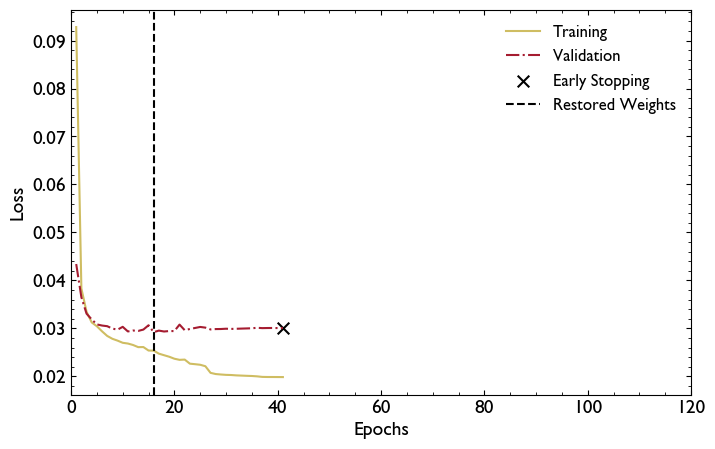

In [10]:
imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
# Load the selected saved model 
p = pred_widget.value
h = hist_widget.value
model = tf.keras.models.load_model(f'{global_path}/{set_id}/{p}')
model.summary()
with open(f'{global_path}/{set_id}/{h}', 'rb') as file:
    summary = pickle.load(file)
#plot the training and validation accuracy and loss at each epoch
sizefont = 14
sizefont2 = 12
plt.rcParams.update({'font.size': sizefont})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

loss = summary['loss']
val_loss = summary['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, c=gold, label='Training')
ax1.plot(epochs, val_loss, c=harvard, linestyle = '-.',label='Validation')
ax1.scatter(epochs[-1], val_loss[-1], marker = 'x', c='black',s=70, label='Early Stopping')
min_index = val_loss.index(min(val_loss))
line = plt.axvline(x=epochs[min_index], color='black',linestyle = '--',label = 'Restored Weights') #52 for stjohns6, 77 for stjohns 16 #61 for 0.001, 128
ax1.set_xlabel('Epochs')
ax1.set_xlim([0,120])
ax1.set_ylabel('Loss')

ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', top=True, right=True)
plt.legend(loc='upper right', frameon=False, fontsize = sizefont2)
# plt.legend(loc='upper center', frameon=False, fontsize = sizefont2)
plt.show()

# from keras.utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='autoencoder.png')

# # Load the image and display it
# img = plt.imread('autoencoder.png')


In [11]:
# y_pred = np.clip(model.predict(X_test),y_min,1)
input_widget_1 = widgets.Dropdown(options=desc[:],value=desc[0],description='Feature :',disabled=False,style = {'description_width': 'initial'}); input_widget_1

Dropdown(description='Feature :', options=('HR HS', 'HR HM', 'HR MS'), style=DescriptionStyle(description_widt…

In [12]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print(mse_test)

import seaborn as sns
import matplotlib.pyplot as plt

# prop = ['hard_hs', 'hard_hm','hard_ms']
# prop = ['var_prob_b','var_prob_h','var_prob_m', 'var_prob_s']

# input_widget = widgets.Dropdown(options=prop[:],value=prop[0],description='Feature :',disabled=False,style = {'description_width': 'initial'}); input_widget

c = desc.index(input_widget_1.value)
y_test_c = y_test[:,c]
y_pred_c = y_pred[:,c]

#1

# Create a density plot with the predicted values on the x-axis and the actual values on the y-axis
sns.kdeplot(y_pred, label='Predicted', linestyle = '--')
sns.kdeplot(y_test, label='Actual', linestyle = '-')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'Predicted vs Actual: {input_widget_1.value}')
plt.legend()
plt.show()

#2

# Create a scatter plot with the predicted values on the x-axis and the actual values on the y-axis
plt.scatter(y_pred_c, y_test_c, s=0.5)
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Predicted vs Actual: {input_widget_1.value}')
plt.show()


#3
sns.kdeplot(x=y_pred_c, y=y_test_c,fill=0, thresh=0.3,legend=True)
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Predicted vs Actual: {input_widget_1.value}')
plt.show()

ValueError: in user code:

    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/steven/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 24, 16, 1), found shape=(None, 384)
